## Setup


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
#!conda activate gnngeometry

In [3]:
import torch
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math, random, torch, collections, time, torch.nn.functional as F, networkx as nx, matplotlib.pyplot as plt, numpy as np
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from IPython.display import clear_output
from torch_geometric.utils import to_networkx
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from functools import wraps

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

/Users/sowonjeong/opt/anaconda3/envs/gnn-geometry/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def visualize_graph(G, color, size=300, epoch=None, loss=None):
    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2", node_size=size)
    plt.show()


def visualize_tsne(out, color, size=30, epoch=None, loss=None):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=size, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss:.4f}', fontsize=16)
    plt.show()


def visualize_pca(out, color, size=30, epoch=None, loss=None):
    h = PCA(n_components=2).fit_transform(out.detach().cpu().numpy())
    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(h[:, 0], h[:, 1], s=size, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss:.4f}', fontsize=16)
    plt.show()


def delete_undirected_edges(edge_index, p):
    edges = torch.clone(edge_index).t().numpy()
    edges = set(map(frozenset, edges))
    n = len(edges)
    edges = random.sample(edges, round(n * (1 - p)))
    edges = list(map(list, edges))
    reverse_edges = list(map(lambda x: [x[1], x[0]], edges))
    sample = sorted(edges + reverse_edges)
    return torch.tensor(sample).t().contiguous()


def add_undirected_edges(edge_index, edge_num, node_total=2708):
    edges = torch.clone(edge_index).t().numpy()
    edges = set(map(frozenset, edges))
    n = len(edges)
    while len(edges) - n < edge_num:
        edges.add(frozenset(random.sample(range(node_total), 2)))
    edges = list(map(list, edges))
    reverse_edges = list(map(lambda x: [x[1], x[0]], edges))
    sample = sorted(edges + reverse_edges)
    return torch.tensor(sample).t().contiguous()


def dataset_print(dataset):
    print(f'Dataset: {dataset}:')
    print('======================')
    print(f'Number of graphs: {len(dataset)}')
    print(f'Number of features: {dataset.num_features}')
    print(f'Number of classes: {dataset.num_classes}')


def data_print(data):
    print(data)
    print('==============================================================')

    # Gather some statistics about the graph.
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Number of training nodes: {data.train_mask.sum()}')
    print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
    print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
    print(f'Contains self-loops: {data.contains_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')


def timethis(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print("Time to run function '{}': {:.2f} seconds".format(func.__name__, end - start))
        return result

    return wrapper


In [5]:
from typing import Optional, Tuple
from torch_geometric.typing import Adj, OptTensor, PairTensor

import torch
from torch import Tensor
from torch.nn import Parameter
from torch_scatter import scatter_add
from torch_sparse import SparseTensor, matmul, fill_diag, sum as sparsesum, mul
from torch_geometric.nn.inits import zeros
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import add_remaining_self_loops
from torch_geometric.utils.num_nodes import maybe_num_nodes

from torch_geometric.datasets import WebKB
from torch_geometric.transforms import NormalizeFeatures
import torch
import torch_geometric as tg
import pandas as pd


@torch.jit._overload
def gcn_norm(edge_index, edge_weight=None, num_nodes=None, improved=False,
             add_self_loops=True, dtype=None):
    # type: (Tensor, OptTensor, Optional[int], bool, bool, Optional[int]) -> PairTensor  # noqa
    pass


@torch.jit._overload
def gcn_norm(edge_index, edge_weight=None, num_nodes=None, improved=False,
             add_self_loops=True, dtype=None):
    # type: (SparseTensor, OptTensor, Optional[int], bool, bool, Optional[int]) -> SparseTensor  # noqa
    pass


def gcn_no_norm(edge_index, edge_weight=None, num_nodes=None, improved=False,
                add_self_loops=True, dtype=None):
    fill_value = 2. if improved else 1.

    if isinstance(edge_index, SparseTensor):
        adj_t = edge_index
        if not adj_t.has_value():
            adj_t = adj_t.fill_value(1., dtype=dtype)
        if add_self_loops:
            adj_t = fill_diag(adj_t, fill_value)
        return adj_t

    else:
        num_nodes = maybe_num_nodes(edge_index, num_nodes)

        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1),), dtype=dtype,
                                     device=edge_index.device)

        if add_self_loops:
            edge_index, tmp_edge_weight = add_remaining_self_loops(
                edge_index, edge_weight, fill_value, num_nodes)
            assert tmp_edge_weight is not None
            edge_weight = tmp_edge_weight
        return edge_index, edge_weight


def gcn_diffusion(edge_index, edge_weight=None, num_nodes=None, improved=False,
                  add_self_loops=True, dtype=None, alpha=0.5, beta = 1.0):
    fill_value = beta

    if isinstance(edge_index, SparseTensor):
        adj_t = edge_index
        if not adj_t.has_value():
            adj_t = adj_t.fill_value(1., dtype=dtype)
        if add_self_loops:
            adj_t = fill_diag(adj_t, fill_value)
        deg = sparsesum(adj_t, dim=1)  # sum of each row of the sparse tensor
        deg_inv_sqrt = deg.pow_(-alpha)
        deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0.)  # put 0. where deg_inv_sprt == inf
        adj_t = mul(adj_t, deg_inv_sqrt.view(-1, 1))
        adj_t = mul(adj_t, deg_inv_sqrt.view(1, -1))  #### L_alpha = D^{-alpha}LD^{-alpha}
        deg = sparsesum(adj_t, dim=1)  #### degree D_alpha
        deg_inv = deg.pow_(-1)
        deg_inv.masked_fill_(deg == float('inf'), 0.)
        adj_t = mul(adj_t, deg_inv.view(1, -1))
        if add_self_loops == False:
            adj_t = fill_diag(adj_t, 1.)
        return adj_t

    else:
        num_nodes = maybe_num_nodes(edge_index, num_nodes)

        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1),), dtype=dtype,
                                     device=edge_index.device)

        if add_self_loops:
            edge_index, tmp_edge_weight = add_remaining_self_loops(
                edge_index, edge_weight, fill_value, num_nodes)
            assert tmp_edge_weight is not None
            edge_weight = tmp_edge_weight
        row, col = edge_index[0], edge_index[1]
        deg = scatter_add(edge_weight, col, dim=0, dim_size=num_nodes)
        # print(deg)
        deg_inv_sqrt = deg.pow_(-alpha)
        deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
        L = deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]
        # print(scatter_add(L, col, dim=0, dim_size=data.num_nodes))
        deg_alpha = scatter_add(L, row, dim=0, dim_size=num_nodes)
        deg_inv = deg_alpha.pow_(-1)
        deg_inv.masked_fill_(deg == float('inf'), 0)
        L = deg_inv[row] * L
        if add_self_loops == False:
            edge_index, tmp_edge_weight = add_remaining_self_loops(
                edge_index, L, fill_value, num_nodes)
            assert tmp_edge_weight is not None
            L = tmp_edge_weight
        return edge_index, L


def gcn_norm(edge_index, edge_weight=None, num_nodes=None,
             improved=False,
             add_self_loops=True, dtype=None, alpha=0.5, beta = 1.0):
    fill_value = beta

    if isinstance(edge_index, SparseTensor):
        adj_t = edge_index
        if not adj_t.has_value():
            adj_t = adj_t.fill_value(1., dtype=dtype)
        if add_self_loops:
            adj_t = fill_diag(adj_t, fill_value)
        deg = sparsesum(adj_t, dim=1)
        deg_inv_sqrt = deg.pow_(-alpha)
        deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0.)
        adj_t = mul(adj_t, deg_inv_sqrt.view(-1, 1))
        adj_t = mul(adj_t, deg_inv_sqrt.view(1, -1))
        if add_self_loops == False:
            adj_t = adj_t.fill_value(fill_value, dtype=dtype)
        return adj_t

    else:
        num_nodes = maybe_num_nodes(edge_index, num_nodes)

        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1),), dtype=dtype,
                                     device=edge_index.device)

        if add_self_loops:
            edge_index, tmp_edge_weight = add_remaining_self_loops(
                edge_index, edge_weight, fill_value, num_nodes)
            assert tmp_edge_weight is not None
            edge_weight = tmp_edge_weight

        row, col = edge_index[0], edge_index[1]
        deg = scatter_add(edge_weight, col, dim=0, dim_size=num_nodes)
        deg_inv_sqrt = deg.pow_(-alpha)
        deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
        L = deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]
        if add_self_loops == False:
            edge_index, tmp_edge_weight = add_remaining_self_loops(
                edge_index, L, fill_value, num_nodes)
            assert tmp_edge_weight is not None
            L = tmp_edge_weight
        return edge_index, L


def gcn_norm_sym(edge_index, alpha=0.5, beta = 1.0, edge_weight=None, num_nodes=None, improved=False,
                 add_self_loops=True, dtype=None):
    fill_value = beta

    if isinstance(edge_index, SparseTensor):
        adj_t = edge_index
        if not adj_t.has_value():
            adj_t = adj_t.fill_value(1., dtype=dtype)
        if add_self_loops:
            adj_t = fill_diag(adj_t, fill_value)
        deg = sparsesum(adj_t, dim=1)  # sum of each row of the sparse tensor
        deg_inv_sqrt = deg.pow_(-alpha)
        deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0.)  # put 0. where deg_inv_sprt == inf
        adj_t = mul(adj_t, deg_inv_sqrt.view(-1, 1))
        adj_t = mul(adj_t, deg_inv_sqrt.view(1, -1))  #### L_alpha = D^{-alpha}LD^{-alpha}
        deg = sparsesum(adj_t, dim=1)  #### degree D_alpha
        deg_inv = deg.pow_(-0.5)
        deg_inv.masked_fill_(deg == float('inf'), 0.)
        adj_t = mul(adj_t, deg_inv.view(1, -1))
        adj_t = mul(adj_t, deg_inv.view(-1, 1))
        if add_self_loops == False:
            adj_t = fill_diag(adj_t, 1.)
        return adj_t

    else:
        num_nodes = maybe_num_nodes(edge_index, num_nodes)

        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1),), dtype=dtype,
                                     device=edge_index.device)

        if add_self_loops:
            edge_index, tmp_edge_weight = add_remaining_self_loops(
                edge_index, edge_weight, fill_value, num_nodes)
            assert tmp_edge_weight is not None
            edge_weight = tmp_edge_weight
        row, col = edge_index[0], edge_index[1]
        deg = scatter_add(edge_weight, col, dim=0, dim_size=num_nodes)
        # print(deg)
        deg_inv_sqrt = deg.pow_(-alpha)
        deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
        L = deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]
        # print(scatter_add(L, col, dim=0, dim_size=data.num_nodes))
        deg_alpha = scatter_add(L, row, dim=0, dim_size=num_nodes)
        deg_inv = deg_alpha.pow_(-0.5)
        deg_inv.masked_fill_(deg == float('inf'), 0)
        L = deg_inv[row] * L * deg_inv[col]
        if add_self_loops == False:
            edge_index, tmp_edge_weight = add_remaining_self_loops(
                edge_index, L, fill_value, num_nodes)
            assert tmp_edge_weight is not None
            L = tmp_edge_weight
        return edge_index, L


class AggregationScheme(MessagePassing):
    r"""The graph convolutional operator from the `"Semi-supervised
    Classification with Graph Convolutional Networks"
    <https://arxiv.org/abs/1609.02907>`_ paper
    .. math::
        \mathbf{X}^{\prime} = \mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
        \mathbf{\hat{D}}^{-1/2} \mathbf{X} \mathbf{\Theta},
    where :math:`\mathbf{\hat{A}} = \mathbf{A} + \mathbf{I}` denotes the
    adjacency matrix with inserted self-loops and
    :math:`\hat{D}_{ii} = \sum_{j=0} \hat{A}_{ij}` its diagonal degree matrix.
    The adjacency matrix can include other values than :obj:`1` representing
    edge weights via the optional :obj:`edge_weight` tensor.
    Its node-wise formulation is given by:
    .. math::
        \mathbf{x}^{\prime}_i = \mathbf{\Theta} \sum_{j \in \mathcal{N}(v) \cup
        \{ i \}} \frac{e_{j,i}}{\sqrt{\hat{d}_j \hat{d}_i}} \mathbf{x}_j
    with :math:`\hat{d}_i = 1 + \sum_{j \in \mathcal{N}(i)} e_{j,i}`, where
    :math:`e_{j,i}` denotes the edge weight from source node :obj:`j` to target
    node :obj:`i` (default: :obj:`1.0`)
    Args:
        in_channels (int): Size of each input sample, or :obj:`-1` to derive
            the size from the first input(s) to the forward method.
        out_channels (int): Size of each output sample.
        improved (bool, optional): If set to :obj:`True`, the layer computes
            :math:`\mathbf{\hat{A}}` as :math:`\mathbf{A} + 2\mathbf{I}`.
            (default: :obj:`False`)
        cached (bool, optional): If set to :obj:`True`, the layer will cache
            the computation of :math:`\mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
            \mathbf{\hat{D}}^{-1/2}` on first execution, and will use the
            cached version for further executions.
            This parameter should only be set to :obj:`True` in transductive
            learning scenarios. (default: :obj:`False`)
        add_self_loops (bool, optional): If set to :obj:`False`, will not add
            self-loops to the input graph. (default: :obj:`True`)
        normalize (bool, optional): Whether to add self-loops and compute
            symmetric normalization coefficients on the fly.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """

    _cached_edge_index: Optional[Tuple[Tensor, Tensor]]
    _cached_adj_t: Optional[SparseTensor]

    def __init__(self, improved: bool = False, cached: bool = False,
                 add_self_loops: bool = True, normalize: bool = True,
                 gnn_type: str = "normal", alpha: float = 0.5,beta: float = 1.0,
                 bias: bool = True, **kwargs):

        kwargs.setdefault('aggr', 'add')
        super(AggregationScheme, self).__init__(**kwargs)

        self.improved = improved
        self.cached = cached
        self.gnn_type = gnn_type
        self.alpha = alpha
        self.beta = beta
        self.add_self_loops = add_self_loops
        self.normalize = normalize

        self._cached_edge_index = None
        self._cached_adj_t = None

    def reset_parameters(self):
        self._cached_edge_index = None
        self._cached_adj_t = None

    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: OptTensor = None) -> Tensor:
        """"""

        if self.normalize:
            if isinstance(edge_index, Tensor):
                cache = self._cached_edge_index
                if cache is None:
                    if self.gnn_type == "normal":
                        edge_index, edge_weight = gcn_norm(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha = self.alpha, beta = self.beta)
                    elif self.gnn_type == "diffusion":
                        print("here")
                        edge_index, edge_weight = gcn_diffusion(  # yapf: disable
                            edge_index,  edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha = self.alpha, beta = self.beta)
                    elif self.gnn_type == "symmetric diffusion":
                        print("here")
                        edge_index, edge_weight = gcn_norm_sym(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha = self.alpha, beta = self.beta)
                    else:
                        edge_index, edge_weight = gcn_no_norm(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops)
                    if self.cached:
                        self._cached_edge_index = (edge_index, edge_weight)
                else:
                    edge_index, edge_weight = cache[0], cache[1]

            elif isinstance(edge_index, SparseTensor):
                cache = self._cached_adj_t
                if cache is None:
                    if self.gnn_type == "normal":
                        edge_index = gcn_norm(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha = self.alpha, beta = self.beta)
                    elif self.gnn_type == "diffusion":
                        edge_index = gcn_diffusion(  # yapf: disable
                            edge_index,  edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha = self.alpha, beta = self.beta)
                    elif self.gnn_type == "symmetric diffusion":
                        edge_index = gcn_norm_sym(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha = self.alpha, beta = self.beta)
                    else:
                        edge_index = gcn_no_norm(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops)
                    if self.cached:
                        self._cached_adj_t = edge_index
                else:
                    edge_index = cache

        # propagate_type: (x: Tensor, edge_weight: OptTensor)
        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=None)

        return out

    def message(self, x_j: Tensor, edge_weight: OptTensor) -> Tensor:
        return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        return matmul(adj_t, x, reduce=self.aggr)

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, 0,
                                   0)


class GCNConv(MessagePassing):
    r"""The graph convolutional operator from the `"Semi-supervised
    Classification with Graph Convolutional Networks"
    <https://arxiv.org/abs/1609.02907>`_ paper
    .. math::
        \mathbf{X}^{\prime} = \mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
        \mathbf{\hat{D}}^{-1/2} \mathbf{X} \mathbf{\Theta},
    where :math:`\mathbf{\hat{A}} = \mathbf{A} + \mathbf{I}` denotes the
    adjacency matrix with inserted self-loops and
    :math:`\hat{D}_{ii} = \sum_{j=0} \hat{A}_{ij}` its diagonal degree matrix.
    The adjacency matrix can include other values than :obj:`1` representing
    edge weights via the optional :obj:`edge_weight` tensor.
    Its node-wise formulation is given by:
    .. math::
        \mathbf{x}^{\prime}_i = \mathbf{\Theta} \sum_{j \in \mathcal{N}(v) \cup
        \{ i \}} \frac{e_{j,i}}{\sqrt{\hat{d}_j \hat{d}_i}} \mathbf{x}_j
    with :math:`\hat{d}_i = 1 + \sum_{j \in \mathcal{N}(i)} e_{j,i}`, where
    :math:`e_{j,i}` denotes the edge weight from source node :obj:`j` to target
    node :obj:`i` (default: :obj:`1.0`)
    Args:
        in_channels (int): Size of each input sample, or :obj:`-1` to derive
            the size from the first input(s) to the forward method.
        out_channels (int): Size of each output sample.
        improved (bool, optional): If set to :obj:`True`, the layer computes
            :math:`\mathbf{\hat{A}}` as :math:`\mathbf{A} + 2\mathbf{I}`.
            (default: :obj:`False`)
        cached (bool, optional): If set to :obj:`True`, the layer will cache
            the computation of :math:`\mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
            \mathbf{\hat{D}}^{-1/2}` on first execution, and will use the
            cached version for further executions.
            This parameter should only be set to :obj:`True` in transductive
            learning scenarios. (default: :obj:`False`)
        add_self_loops (bool, optional): If set to :obj:`False`, will not add
            self-loops to the input graph. (default: :obj:`True`)
        normalize (bool, optional): Whether to add self-loops and compute
            symmetric normalization coefficients on the fly.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """

    _cached_edge_index: Optional[Tuple[Tensor, Tensor]]
    _cached_adj_t: Optional[SparseTensor]

    def __init__(self, in_channels: int, out_channels: int,
                 improved: bool = False, cached: bool = False,
                 add_self_loops: bool = True, normalize: bool = True,
                 gnn_type: str = "normal", alpha: float = 0.5,beta: float = 1.0,
                 bias: bool = True,
                 **kwargs):

        kwargs.setdefault('aggr', 'add')
        super(GCNConv, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.improved = improved
        self.cached = cached
        self.gnn_type = gnn_type
        self.alpha = alpha
        self.beta = beta
        self.add_self_loops = add_self_loops
        self.normalize = normalize

        self._cached_edge_index = None
        self._cached_adj_t = None

        self.lin = Linear(in_channels, out_channels, bias=False)
        torch.nn.init.xavier_normal_(self.lin.weight, gain=0.003)

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        zeros(self.bias)
        self._cached_edge_index = None
        self._cached_adj_t = None

    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: OptTensor = None) -> Tensor:
        """"""

        if self.normalize:
            if isinstance(edge_index, Tensor):
                cache = self._cached_edge_index
                if cache is None:
                    if self.gnn_type == "normal":
                        edge_index, edge_weight = gcn_norm(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha=self.alpha, beta = self.beta)
                    elif self.gnn_type == "diffusion":
                        edge_index, edge_weight = gcn_diffusion(  # yapf: disable
                            edge_index,  edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha=self.alpha, beta = self.beta)
                    elif self.gnn_type == "symmetric diffusion":
                        edge_index, edge_weight = gcn_norm_sym(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha=self.alpha, beta = self.beta)
                    else:
                        edge_index, edge_weight = gcn_no_norm(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops)
                    if self.cached:
                        self._cached_edge_index = (edge_index, edge_weight)
                else:
                    edge_index, edge_weight = cache[0], cache[1]

            elif isinstance(edge_index, SparseTensor):
                cache = self._cached_adj_t
                if cache is None:
                    if self.gnn_type == "normal":
                        edge_index = gcn_norm(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha=self.alpha, beta = self.beta)
                    elif self.gnn_type == "diffusion":
                        edge_index = gcn_diffusion(  # yapf: disable
                            edge_index,edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha=self.alpha, beta = self.beta)
                    elif self.gnn_type == "symmetric diffusion":
                        edge_index, edge_weight = gcn_norm_sym(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha=self.alpha, beta = self.beta)
                    else:
                        edge_index = gcn_no_norm(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops)
                    if self.cached:
                        self._cached_adj_t = edge_index
                else:
                    edge_index = cache

        x = self.lin(x)
        # x2 = self.lin2(x)
        # propagate_type: (x: Tensor, edge_weight: OptTensor)
        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=None)

        if self.bias is not None:
            out += self.bias

        return out

    def message(self, x_j: Tensor, edge_weight: OptTensor) -> Tensor:
        return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        return matmul(adj_t, x, reduce=self.aggr)

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)

In [6]:
mask = collections.namedtuple('mask', ('train', 'test'))  # tuple to store train mask, test mask


def train_one_epoch(model, criterion, optimizer, x, y, train_mask=None):  # x is a dictionary
    model.train()
    out, h = model(**x)
    loss = criterion(out, y) if train_mask is None else criterion(out[train_mask], y[train_mask])
    _, predicted = torch.max(out.detach(), 1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        if train_mask is None:
            length = len(y)
            accuracy = (predicted == y).sum().item() / length
            misclassified = (predicted != y).numpy()
        else:
            length = len(y[train_mask])
            accuracy = (predicted[train_mask] == y[train_mask].detach()).sum().item() / length
            misclassified = (predicted[train_mask] != y[train_mask]).numpy()

    return out, loss.item(), accuracy, misclassified


def test(model, x, y, test_mask=None):  # x is a dictionary
    model.eval()
    with torch.no_grad():
        out, h = model(**x)
        _, predicted = torch.max(out, 1)
        if test_mask is None:
            length = len(y)
            accuracy = (predicted == y).sum().item() / length
        else:
            length = len(y[test_mask])
            accuracy = (predicted[test_mask] == y[test_mask]).sum().item() / length
    return accuracy, predicted[test_mask].numpy()


def plot_acc(train_acc, test_acc=None, xaxis='epochs', yaxis='accuracy', title='Accuracy plot'):
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    if test_acc is not None:
        plt.plot(np.arange(len(train_acc)), train_acc, color='red')
        plt.plot(np.arange(len(test_acc)), test_acc, color='blue')
        plt.legend(['train accuracy', 'test accuracy'], loc='upper right')
    else:
        plt.plot(np.arange(len(train_acc)), train_acc, color='red')
        plt.legend(['train accuracy'], loc='upper right')
    plt.title(title)
    plt.tight_layout()
    plt.show()  # show train_acc and test_acc together


def plot_loss(loss, xaxis='epochs', yaxis='loss', title='Loss plot'):
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.plot(np.arange(len(loss)), loss, color='black')
    plt.title(title)
    plt.tight_layout()
    plt.show()


@timethis
def train(epochs, model, criterion, optimizer, x, y, m=mask(None, None),
          plotting=True, scatter_size=30, plotting_freq=5, dim_reduction='pca'):
    dim_reduction_dict = {'pca': visualize_pca, 'tsne': visualize_tsne}
    train_acc_list = []
    test_acc_list = []
    loss_list = []
    for epoch in range(epochs):
        out, loss, train_acc, misclassified = train_one_epoch(model, criterion, optimizer, x, y, m.train)
        model.eval()
        test_acc, predictions = test(model, x, y, m.test)
        train_acc_list.append(train_acc)
        loss_list.append(loss)
        test_acc_list.append(test_acc)
        if plotting:
            if epoch % plotting_freq == 0:
                clear_output(wait=True)
                dim_reduction_dict[dim_reduction](out, color=y, size=scatter_size, epoch=epoch, loss=loss)
    if plotting:
        if m == mask(None, None):
            plot_acc(train_acc_list)
        else:
            plot_acc(train_acc_list, test_acc_list)
        plot_loss(loss_list)
    print("Final test accuracy: {:.2f}".format(test_acc_list[-1]))
    return train_acc_list, test_acc_list, loss_list, misclassified, predictions, out

## Generate Spheres

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import torch
from sklearn.neighbors import kneighbors_graph
import scipy as sc
import sklearn as sk
from sklearn.preprocessing import StandardScaler
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix, to_undirected

def generate_sphere(r=1, alpha = 1, beta = 1, seed = 1234, n_samples = 3000, n_neighbours = 5, features = 'coordinates', standardize=True):
  random.seed(1234)
  theta = 2 * math.pi * np.random.beta(a = alpha,b = beta, size= n_samples)
  phi =  math.pi * np.random.beta(a = alpha, b = beta, size = n_samples)
  x = r * np.cos(theta) * np.sin(phi)
  y = r * np.sin(theta) * np.sin(phi)
  z = r * np.cos(phi)
  X = np.vstack([np.array(x), np.array(y), np.array(z)]).T
  A = kneighbors_graph(X, n_neighbours, mode='distance', include_self=False)
  edge_index, edge_weights = from_scipy_sparse_matrix(A)
  edge_index, edge_weights = to_undirected(edge_index, edge_weights)
  if standardize:
      preproc = StandardScaler()
      X = preproc.fit_transform(X)
  if features == 'coordinates':
      new_data = Data(x=torch.from_numpy(X).float(),
                      edge_index=edge_index,
                      edge_weight=edge_weights)
  else:
      new_data = Data(x=torch.eye(n_samples), edge_index=edge_index,
                      edge_weight=edge_weights)
  return x,y,z, A, new_data

In [8]:
def generate_helix(alpha = 1, beta = 1, seed = 1234, n_samples = 3000, n_neighbours = 5, features = 'coordinates', standardize=True):
  random.seed(1234)
  theta = 8 * math.pi * np.random.beta(a = alpha,b = beta, size= n_samples)
  phi = 4 * math.pi * np.random.beta(a = alpha, b = beta, size = n_samples)
  n =  np.random.uniform(0,1,n_samples)
  #x=(1.2+0.1*np.cos(phi))*np.cos(theta)
  #y=(1.2+0.1*np.cos(phi))*np.sin(theta)
  theta = np.sort(theta)
  x = n*np.cos(theta)
  y = n*np.sin(theta)
  #z=0.1*np.sin(phi)+theta/np.pi
  z = theta/np.pi 
  X = np.vstack([np.array(x), np.array(y), np.array(z)]).T
  A = kneighbors_graph(X, n_neighbours, mode='distance', include_self=False)
  edge_index, edge_weights = from_scipy_sparse_matrix(A)
  edge_index, edge_weights = to_undirected(edge_index, edge_weights)
  if standardize:
      preproc = StandardScaler()
      X = preproc.fit_transform(X)
  if features == 'coordinates':
      new_data = Data(x=torch.from_numpy(X).float(),
                      edge_index=edge_index,
                      edge_weight=edge_weights)
  else:
      new_data = Data(x=torch.eye(n_samples), edge_index=edge_index,
                      edge_weight=edge_weights)
  return x,y,z, A, new_data

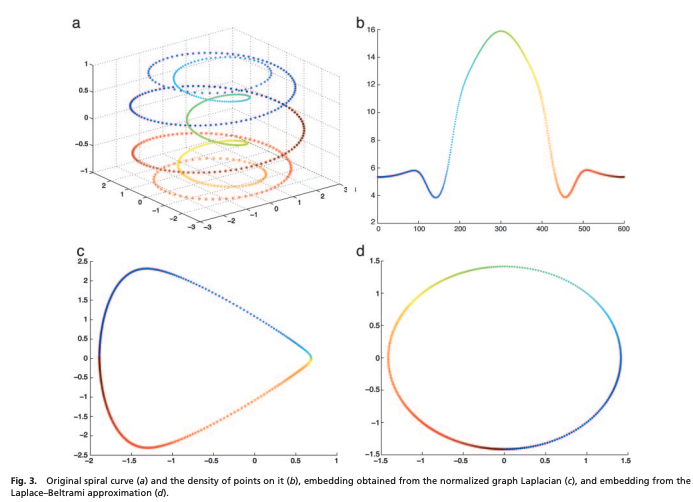

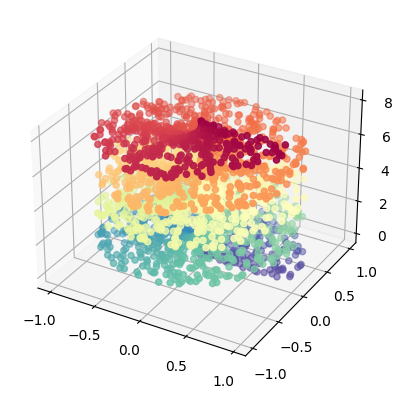

In [9]:
x,y,z,A,new_data = generate_helix(alpha = 1, beta = 1)

fig = plt.figure()
ax = plt.axes(projection ='3d')

# plotting
ax.scatter(x,y,z, cmap = plt.cm.Spectral_r, c = z)
#ax.plot(x,y,z)
plt.show()

<Figure size 640x480 with 0 Axes>

/var/folders/52/dh42902j7rv__r8tnhmqf8_w0000gn/T/ipykernel_46161/1736191027.py:2: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  nx.draw_networkx(nx.from_scipy_sparse_matrix(A),


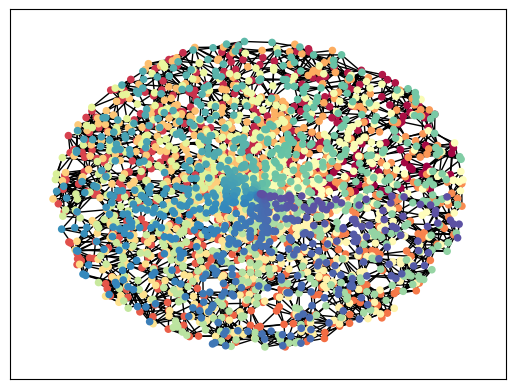

In [10]:
plt.figure()
nx.draw_networkx(nx.from_scipy_sparse_matrix(A),
                 pos={i:[new_data.x[i,0].numpy(),new_data.x[i,1].numpy()] for i in range(new_data.num_nodes)},
                 # to see the "roll" it should by x, y axis
                 node_color=z, cmap='Spectral', with_labels=False, node_size = 20)
plt.show()

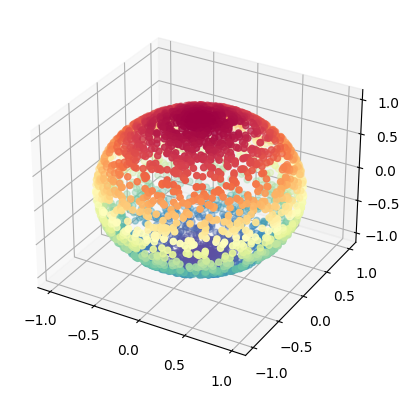

In [11]:
x,y,z,A,new_data = generate_sphere(alpha = 1, beta = 1)

fig = plt.figure()
ax = plt.axes(projection ='3d')
 
# plotting
ax.scatter(x,y,z ,c = z, cmap = plt.cm.Spectral_r)
plt.show()

<Figure size 640x480 with 0 Axes>

/var/folders/52/dh42902j7rv__r8tnhmqf8_w0000gn/T/ipykernel_46161/779525772.py:2: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  nx.draw_networkx(nx.from_scipy_sparse_matrix(A),


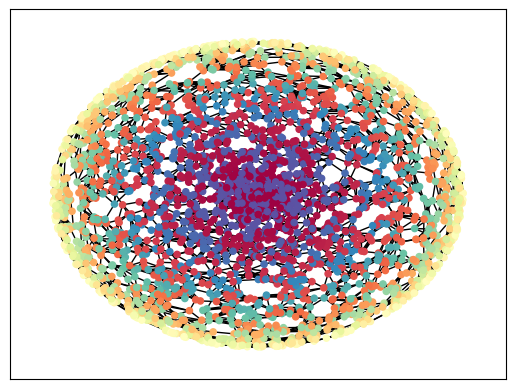

In [12]:
plt.figure()
nx.draw_networkx(nx.from_scipy_sparse_matrix(A),
                 pos={i:[new_data.x[i,0].numpy(),new_data.x[i,1].numpy()] for i in range(new_data.num_nodes)},
                 # to see the "roll" it should by x, y axis
                 node_color=z, cmap='Spectral_r', with_labels=False, node_size = 20)
plt.show()

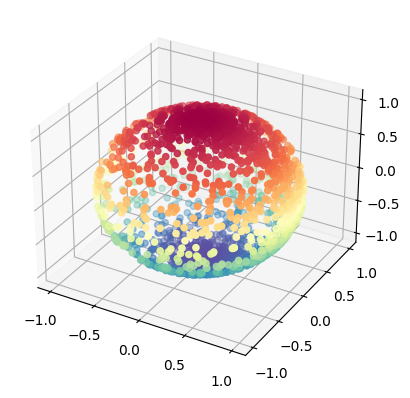

In [13]:
x,y,z,A,new_data = generate_sphere(alpha = 0.5, beta = 0.5)

fig = plt.figure()
ax = plt.axes(projection ='3d')
 
# plotting
ax.scatter(x,y,z ,c = z, cmap = plt.cm.Spectral_r)
plt.show()

<Figure size 640x480 with 0 Axes>

/var/folders/52/dh42902j7rv__r8tnhmqf8_w0000gn/T/ipykernel_46161/779525772.py:2: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  nx.draw_networkx(nx.from_scipy_sparse_matrix(A),


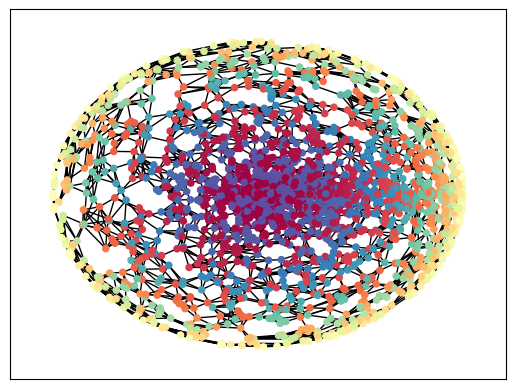

In [14]:
plt.figure()
nx.draw_networkx(nx.from_scipy_sparse_matrix(A),
                 pos={i:[new_data.x[i,0].numpy(),new_data.x[i,1].numpy()] for i in range(new_data.num_nodes)},
                 # to see the "roll" it should by x, y axis
                 node_color=z, cmap='Spectral_r', with_labels=False, node_size = 20)
plt.show()

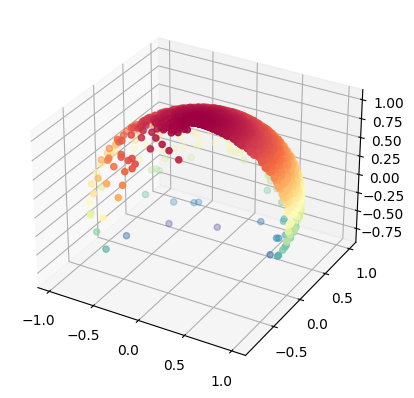

In [15]:
x,y,z,A,new_data = generate_sphere(alpha = 1, beta = 5)

fig = plt.figure()
ax = plt.axes(projection ='3d')
 
# plotting
ax.scatter(x,y,z ,c = z, cmap = plt.cm.Spectral_r)
plt.show()

<Figure size 640x480 with 0 Axes>

/var/folders/52/dh42902j7rv__r8tnhmqf8_w0000gn/T/ipykernel_46161/3349307350.py:2: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  nx.draw_networkx(nx.from_scipy_sparse_matrix(A),


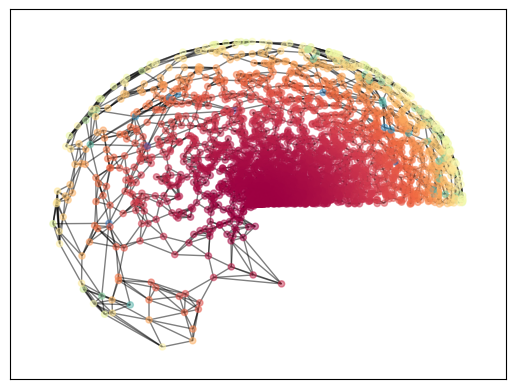

In [16]:
plt.figure()
nx.draw_networkx(nx.from_scipy_sparse_matrix(A),
                 pos={i:[new_data.x[i,0].numpy(),new_data.x[i,1].numpy()] for i in range(new_data.num_nodes)},
                 # to see the "roll" it should by x, y axis
                 node_color=z, cmap='Spectral_r', with_labels=False, node_size = 20, alpha = 0.5)
plt.show()

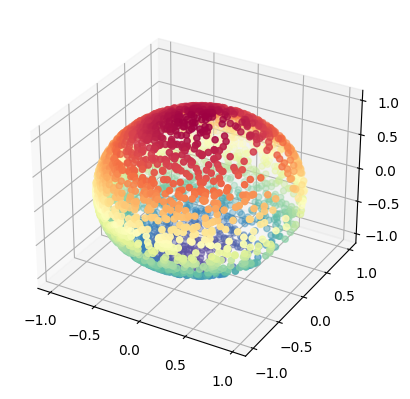

In [17]:
x,y,z,A,new_data = generate_sphere(alpha = 2, beta = 2)

fig = plt.figure()
ax = plt.axes(projection ='3d')
 
# plotting
ax.scatter(x,y,z ,c = z, cmap = plt.cm.Spectral_r)
plt.show()

<Figure size 640x480 with 0 Axes>

/var/folders/52/dh42902j7rv__r8tnhmqf8_w0000gn/T/ipykernel_46161/779525772.py:2: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  nx.draw_networkx(nx.from_scipy_sparse_matrix(A),


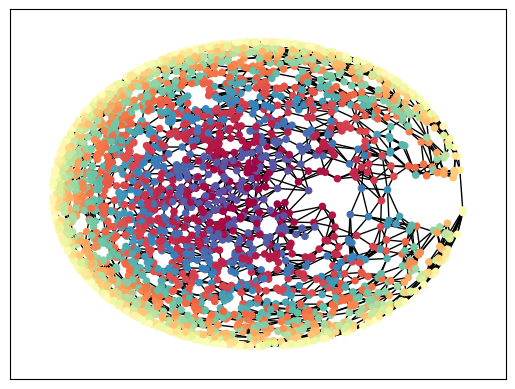

In [18]:
plt.figure()
nx.draw_networkx(nx.from_scipy_sparse_matrix(A),
                 pos={i:[new_data.x[i,0].numpy(),new_data.x[i,1].numpy()] for i in range(new_data.num_nodes)},
                 # to see the "roll" it should by x, y axis
                 node_color=z, cmap='Spectral_r', with_labels=False, node_size = 20)
plt.show()

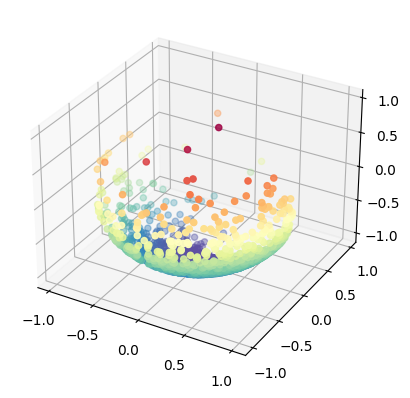

In [19]:
x,y,z,A,new_data = generate_sphere(alpha = 5, beta = 1)

fig = plt.figure()
ax = plt.axes(projection ='3d')
 
# plotting
ax.scatter(x,y,z ,c = z, cmap = plt.cm.Spectral_r)
plt.show()

<Figure size 640x480 with 0 Axes>

/var/folders/52/dh42902j7rv__r8tnhmqf8_w0000gn/T/ipykernel_46161/779525772.py:2: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  nx.draw_networkx(nx.from_scipy_sparse_matrix(A),


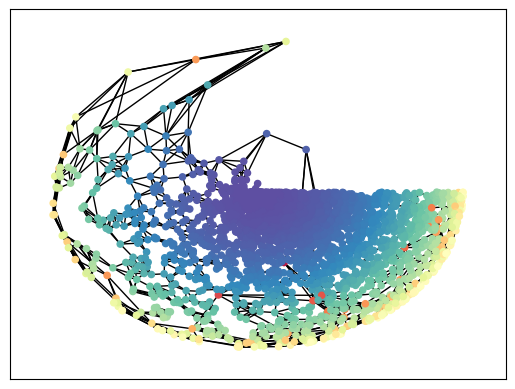

In [20]:
plt.figure()
nx.draw_networkx(nx.from_scipy_sparse_matrix(A),
                 pos={i:[new_data.x[i,0].numpy(),new_data.x[i,1].numpy()] for i in range(new_data.num_nodes)},
                 # to see the "roll" it should by x, y axis
                 node_color=z, cmap='Spectral_r', with_labels=False, node_size = 20)
plt.show()

In [21]:
cd /Users/sowonjeong/Documents/GitHub/GNN-Geometry

/Users/sowonjeong/Documents/GitHub/GNN-Geometry


In [22]:
from models.dgi import *
from models.train_models import train_dgi
from models.baseline_models import *

In [23]:
# cd /Users/sowonjeong/Documents/GitHub/GNN-Geometry/notebook

/Users/sowonjeong/Documents/GitHub/GNN-Geometry/notebook


In [24]:
_,_,c,_,dataset = generate_sphere(alpha = 1, beta = 5)

In [25]:
out = {}
alpha = np.arange(0.0,1.1,0.1)
for i in np.arange(10):
    model = train_dgi(dataset,hid_dim = 32, out_dim = 2, n_layers = 2, patience=50,
              epochs=500, lr=1e-2, name_file="1", device=None, alpha = alpha[i], beta = 1, add_self_loops = True, dropout_rate = 0.01)
    out_tmp = model.get_embedding(dataset)
    out[i] = out_tmp

=== train DGI model ===
Epoch=000, loss=0.6979, time=0.1008
Epoch=001, loss=0.6471, time=0.0776
Epoch=002, loss=0.6307, time=0.0535
Epoch=003, loss=0.6205, time=0.0520
Epoch=004, loss=0.6164, time=0.0491
Epoch=005, loss=0.6040, time=0.0530
Epoch=006, loss=0.5931, time=0.0467
Epoch=007, loss=0.5836, time=0.0481
Epoch=008, loss=0.5870, time=0.0480
Epoch=009, loss=0.5753, time=0.0500
Epoch=010, loss=0.5740, time=0.0489
Epoch=011, loss=0.5601, time=0.0494
Epoch=012, loss=0.5608, time=0.0707
Epoch=013, loss=0.5373, time=0.0220
Epoch=014, loss=0.5445, time=0.0466
Epoch=015, loss=0.5601, time=0.0457
Epoch=016, loss=0.5540, time=0.0476
Epoch=017, loss=0.5495, time=0.0474
Epoch=018, loss=0.5472, time=0.0478
Epoch=019, loss=0.5475, time=0.0482
Epoch=020, loss=0.5427, time=0.0194
Epoch=021, loss=0.5366, time=0.0497
Epoch=022, loss=0.5277, time=0.0773
Epoch=023, loss=0.5285, time=0.0188
Epoch=024, loss=0.5258, time=0.0794
Epoch=025, loss=0.5132, time=0.0209
Epoch=026, loss=0.5161, time=0.0456
Epoc

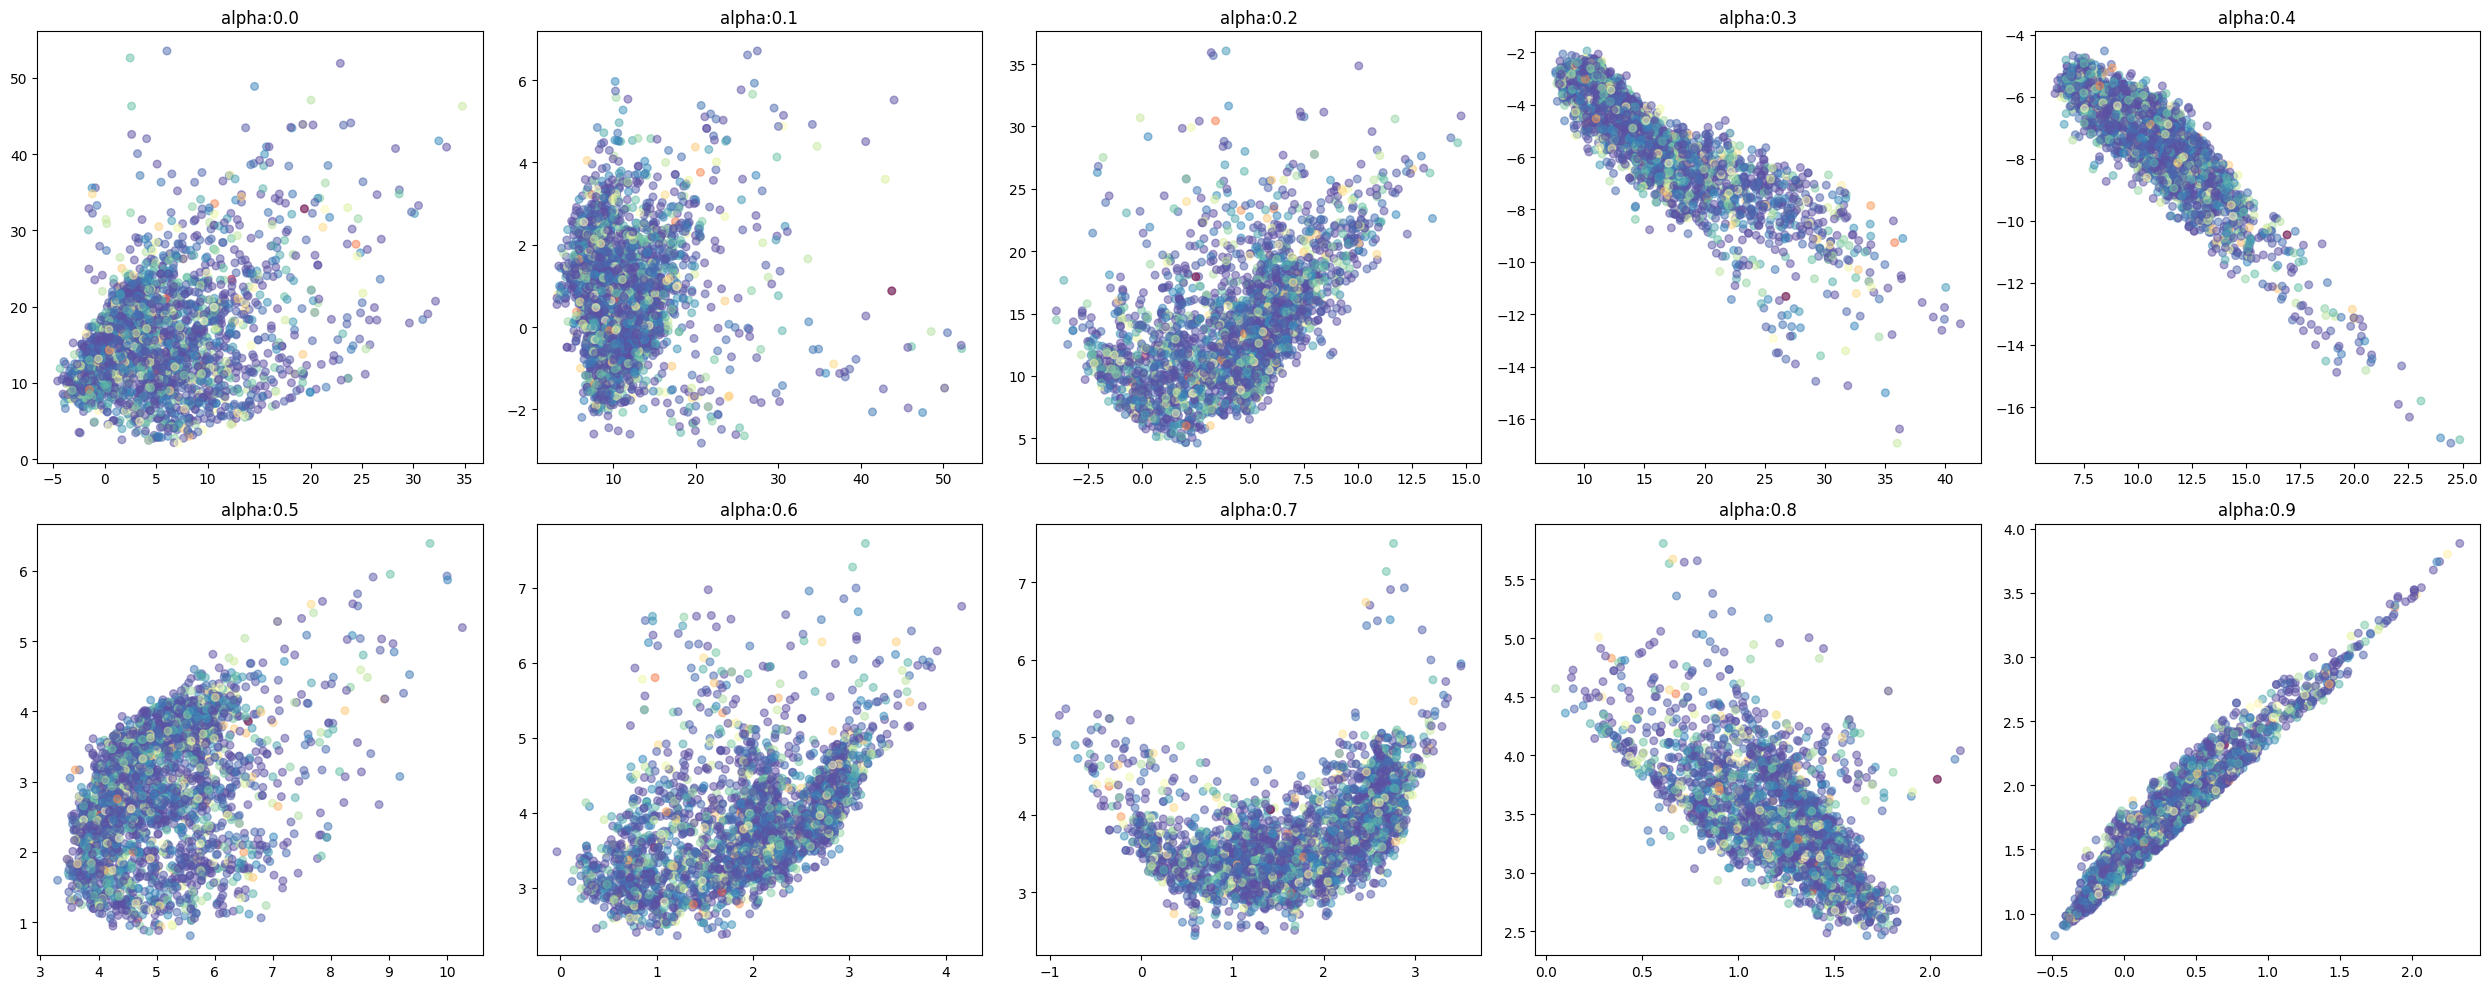

In [26]:
# dropout = 0.01
num = 10
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(5*num_col,5*num_row))
for i in range(num):
    ax = axes[i // num_col, i % num_col]
    _ = ax.scatter(out[i].detach().numpy()[:,0],out[i].detach().numpy()[:,1], c = z, cmap = plt.cm.Spectral_r, s = 30, alpha = 0.5)
    _ = ax.set_title('alpha:' + str(round(alpha[i],1)))
plt.tight_layout()
plt.show()

In [27]:
from models.grace import *
from models.train_models import train_grace
from models.baseline_models import *

In [32]:
out = {}
alpha = np.arange(0.0,1.1,0.1)
for i in np.arange(10):
    model = train_grace(dataset, 32, 2, n_layers=1, tau=0.5,
                epochs=500, wd=1e-3, lr=5e-1, fmr=0.2, edr =0.5,
                proj="nonlinear-hid", name_file="test", device=None,
                gnn_type="symmetric", alpha=alpha[i], beta = 1,add_self_loops= True)
    out_tmp = model.get_embedding(dataset)
    out[i] = out_tmp


=== train GRACE model ===
Epoch=000, loss=8.5620
Epoch=001, loss=8.2684
Epoch=002, loss=8.3278
Epoch=003, loss=8.4318
Epoch=004, loss=8.8176
Epoch=005, loss=8.3318
Epoch=006, loss=8.3020
Epoch=007, loss=8.1790
Epoch=008, loss=8.4648
Epoch=009, loss=8.0583
Epoch=010, loss=8.4460
Epoch=011, loss=8.8935
Epoch=012, loss=8.5080
Epoch=013, loss=8.0668
Epoch=014, loss=8.0685
Epoch=015, loss=8.4850
Epoch=016, loss=8.1225
Epoch=017, loss=9.4078
Epoch=018, loss=8.0848
Epoch=019, loss=8.1012
Epoch=020, loss=8.3298
Epoch=021, loss=8.0852
Epoch=022, loss=8.8768
Epoch=023, loss=8.2695
Epoch=024, loss=8.2098
Epoch=025, loss=7.9681
Epoch=026, loss=8.1167
Epoch=027, loss=8.3722
Epoch=028, loss=7.8615
Epoch=029, loss=8.3895
Epoch=030, loss=8.2188
Epoch=031, loss=8.3640
Epoch=032, loss=8.3416
Epoch=033, loss=7.9509
Epoch=034, loss=8.1505
Epoch=035, loss=7.9193
Epoch=036, loss=7.9071
Epoch=037, loss=8.0920
Epoch=038, loss=8.7161
Epoch=039, loss=7.8795
Epoch=040, loss=8.1471
Epoch=041, loss=8.0364
Epoch=04

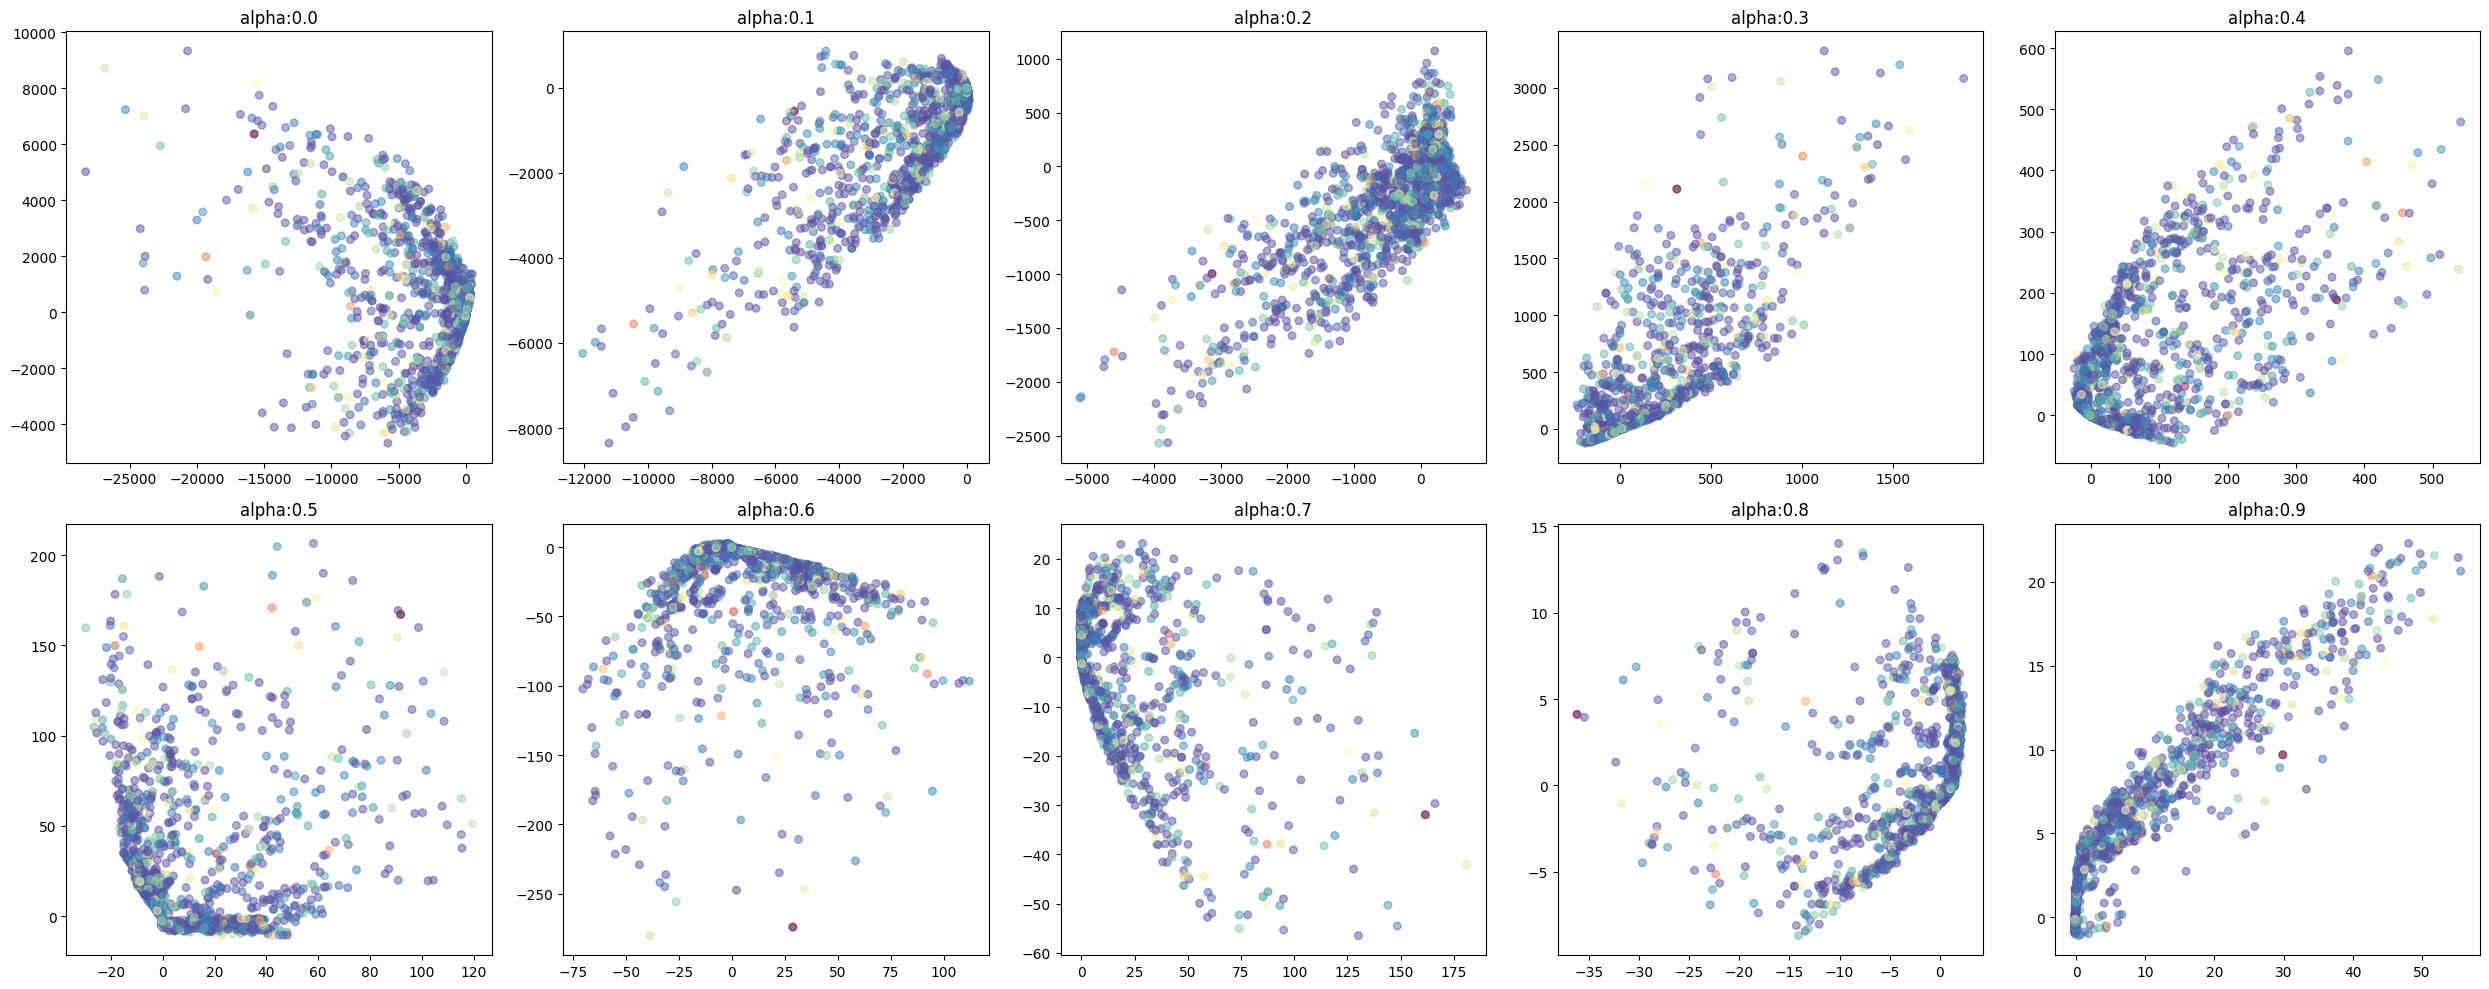

In [ ]:
num = 10
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(5*num_col,5*num_row))
for i in range(num):
    ax = axes[i // num_col, i % num_col]
    _ = ax.scatter(out[i].detach().numpy()[:,0],out[i].detach().numpy()[:,1], c = z, cmap = plt.cm.Spectral_r, s = 30, alpha = 0.5)
    _ = ax.set_title('alpha:' + str(round(alpha[i],1)))
plt.tight_layout()
plt.show()